# Práctico librería implicit - ALS y BPR

Clase: IIC3633 Sistemas Recomendadores, PUC Chile

En este práctico vamos a utilizar la biblioteca de Python [implicit](https://implicit.readthedocs.io/en/latest/quickstart.html) para recomendación utilizando ALS y BPR. 


In [1]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    219      0 --:--:--  0:00:01 --:--:--   219
100 1546k  100 1546k    0     0   704k      0  0:00:02  0:00:02 --:--:--  704k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    431      0 --:--:-- --:--:-- --:--:--   431
100  385k  100  385k    0     0   329k      0  0:00:01  0:00:01 --:--:-- 6654k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    584      0 --:--:-- --:--:-- --:--:--   584
100  230k  100  230k    0     0   237k      0 --:--:-- --:--:-- --:--:-- 2404k


In [2]:
!pip3 install implicit --upgrade

     |████████████████████████████████| 1.1 MB 8.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for implicit: filename=implicit-0.4.8-cp37-cp37m-linux_x86_64.whl size=4503578 sha256=e76863d96b6a37e631a69277055d5ff31a293fd596d80f57170f2151c401fb58
  Stored in directory: /root/.cache/pip/wheels/88/e6/34/25e73cccbaf1a961154bb562a5f86123b68fdbf40e306073d6
Successfully built implicit


In [3]:
import pandas as pd
import numpy as np
import implicit
import scipy.sparse as sparse

In [4]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [5]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
df_train.rating = [1 if x >=3 else 0 for x in df_train.rating ]

In [6]:
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,1,878542960
1,1,4,1,876893119
2,1,5,1,889751712
3,1,6,1,887431973
4,1,7,1,875071561


In [7]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')

In [8]:
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [9]:
# Cargamos el dataset de testing
df_test = pd.read_csv('u2.test',
                      sep='\t',
                      names=['userid', 'itemid', 'rating', 'timestamp'],
                      header=None)


# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0) 
df_test.rating = [1 if x >=3 else 0 for x in df_test.rating ]


user_items_test = {}

for row in df_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []
        
    user_items_test[row[1]].append(row[2])

In [10]:
df_test.head()

,userid,itemid,rating,timestamp
0,1,1,1,874965758
1,1,2,1,876893171
2,1,8,0,875072484
3,1,9,1,878543541
4,1,21,0,878542772


### Métricas

In [11]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])
  
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

### Preprocesamiento de los datos a formato sparse

In [12]:
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []
        
    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)
    
matrix = sparse.csr_matrix(sparse_matrix.T)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
user_item_matrix = matrix.T.tocsr()

In [13]:
def evaluate_model(model, n):
  mean_map = 0.
  mean_ndcg = 0.
  for u in user_items_test.keys():
    rec = [t[0] for t in model.recommend(u, user_item_matrix, n)]
    rel_vector = [np.isin(user_items_test[u], rec, assume_unique=True).astype(int)]
    mean_map += mean_average_precision(rel_vector)
    mean_ndcg += ndcg_at_k(rel_vector, n)

  mean_map /= len(user_items_test)
  mean_ndcg /= len(user_items_test)
  
  return mean_map, mean_ndcg

In [14]:
def show_recommendations(model, user, n):
  recommendations = [t[0] for t in model.recommend(user, user_item_matrix, n)]
  return df_items.loc[recommendations]['title']

In [15]:
def show_similar_movies(model, item, n=10):
  sim_items = [t[0] for t in model.similar_items(item, n)]
  return df_items.loc[sim_items]['title']

## ALS (Implicit Feedback)

**Pregunta 1:** Explique brevemente cómo funciona el algoritmo ALS.

**Respuesta:** ALS significa Alternating Least Squares y esto es porque el modelo se puede entrenar haciendo alternadamente least squares para los parametros, esto es gracias a las propiedades algebraicas del problema. En si el modelo busca encontrar vectores para usuarios e items de manera tal que su producto punto prediga correctamente si el usuario ha consumido o no el item con cierta confianza.

In [16]:
# Definimos y entrenamos el modelo con optimización ALS
model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=10, use_gpu=False)
model_als.fit(matrix)

  0%|          | 0/10 [00:00<?, ?it/s]

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [17]:
show_recommendations(model_als, user=77, n=10)

movieid
292                                      Rosewood (1997)
257                                  Men in Black (1997)
258                                       Contact (1997)
256    When the Cats Away (Chacun cherche son chat) (...
273                                          Heat (1995)
409                                          Jack (1996)
299                                       Hoodlum (1997)
545                           Vampire in Brooklyn (1995)
864                           My Fellow Americans (1996)
754                                    Red Corner (1997)
Name: title, dtype: object

In [18]:
maprec, ndcg = evaluate_model(model_als, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.06539923864477304
ndcg: 0.3460949464012251


**Pregunta 2:** Pruebe distintos valores para los parámetros de ALS y muestre gráficos de cómo se ven afectadas las métricas recién mostradas.

In [22]:
factors_map = []
factors_ndcg = []
for factors in [50, 100, 150, 200, 250]:
  # Definimos y entrenamos el modelo con optimización ALS
  model_als = implicit.als.AlternatingLeastSquares(factors=factors, iterations=10, use_gpu=False)
  model_als.fit(matrix)
  maprec, ndcg = evaluate_model(model_als, n=10)
  factors_map.append(maprec)
  factors_ndcg.append(ndcg)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

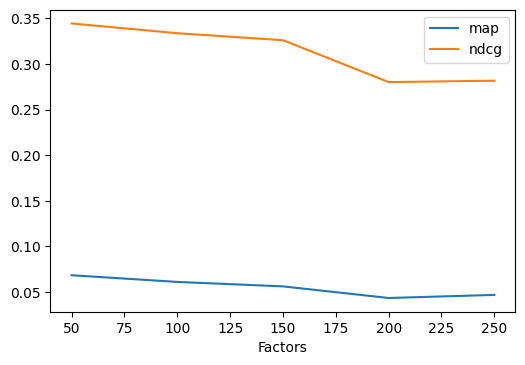

In [25]:
import matplotlib.pyplot as plt

plt.figure(dpi=100)

plt.plot([50, 100, 150, 200, 250], factors_map, label="map")
plt.plot([50, 100, 150, 200, 250], factors_ndcg, label="ndcg")
plt.xlabel("Factors")
plt.legend()

plt.show()

In [27]:
iterations_map = []
iterations_ndcg = []
for iterations in [10, 20, 50, 100]:
  # Definimos y entrenamos el modelo con optimización ALS
  model_als = implicit.als.AlternatingLeastSquares(factors=200, iterations=iterations, use_gpu=False)
  model_als.fit(matrix)
  maprec, ndcg = evaluate_model(model_als, n=10)
  iterations_map.append(maprec)
  iterations_ndcg.append(ndcg)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

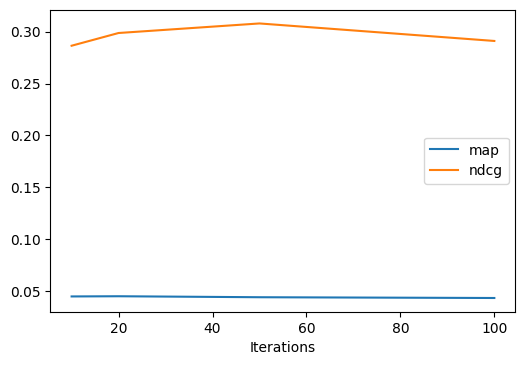

In [29]:
plt.figure(dpi=100)

plt.plot([10, 20, 50, 100], iterations_map, label="map")
plt.plot([10, 20, 50, 100], iterations_ndcg, label="ndcg")
plt.xlabel("Iterations")
plt.legend()

plt.show()

## BPR

**Pregunta 3:** Explique con sus palabras la intuición del framework BPR.

BPR toma una perspectiva bayesiana del problema de ranking, el objetivo es hacer que el modelo prediga un ordenamiento que daria un usuario a los items y no los ratings de cada item. Para realizar el entrenamiento se pueden utilizar tuplas (usuario, item1, item2) donde el item1 precede al item2 en un ranking. La idea de si un item precede a otro en el ranking viene de si el usuario consumio el item1 pero no el item2.

In [30]:
# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=40, use_gpu=False)
model_bpr.fit(matrix)

  0%|          | 0/40 [00:00<?, ?it/s]

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [31]:
show_recommendations(model_bpr, user=77, n=10)

movieid
299                                    Hoodlum (1997)
257                               Men in Black (1997)
285                             Secrets & Lies (1996)
332                             Kiss the Girls (1997)
312    Midnight in the Garden of Good and Evil (1997)
244                     Smilla's Sense of Snow (1997)
327                                   Cop Land (1997)
746                                Real Genius (1985)
300                              Air Force One (1997)
301                                   In & Out (1997)
Name: title, dtype: object

In [32]:
show_similar_movies(model_bpr, item=171, n=10)

movieid
171              Delicatessen (1991)
209        This Is Spinal Tap (1984)
21     Muppet Treasure Island (1996)
68                  Crow, The (1994)
78                 Free Willy (1993)
203                Unforgiven (1992)
27                   Bad Boys (1995)
194                Sting, The (1973)
95                    Aladdin (1992)
264                     Mimic (1997)
Name: title, dtype: object

In [33]:
maprec, ndcg = evaluate_model(model_bpr, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.05820906364222185
ndcg: 0.3552833078101072


**Pregunta 4:** Pruebe distintos valores para los parámetros de BPR y muestre gráficos de cómo se ven afectadas las métricas de ranking (nDCG@10 y MAP) recién mostradas.

In [34]:
factors_map = []
factors_ndcg = []
for factors in [300, 350, 400, 450, 500]:
  # Definimos y entrenamos el modelo con optimización ALS
  model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=factors, iterations=40, use_gpu=False)
  model_bpr.fit(matrix)
  maprec, ndcg = evaluate_model(model_bpr, n=10)

  factors_map.append(maprec)
  factors_ndcg.append(ndcg)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

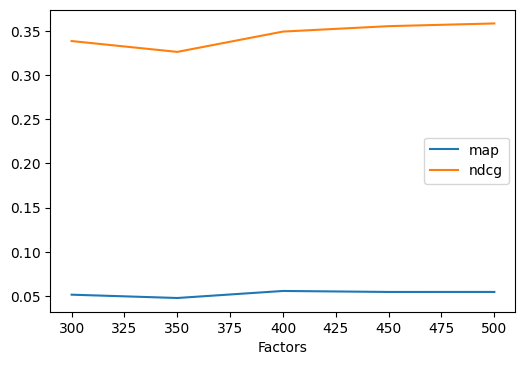

In [35]:
import matplotlib.pyplot as plt

plt.figure(dpi=100)

plt.plot([300, 350, 400, 450, 500], factors_map, label="map")
plt.plot([300, 350, 400, 450, 500], factors_ndcg, label="ndcg")
plt.xlabel("Factors")
plt.legend()

plt.show()

In [36]:
iterations_map = []
iterations_ndcg = []
for iterations in [10, 20, 50, 100]:
  # Definimos y entrenamos el modelo con optimización ALS
  model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=factors, iterations=40, use_gpu=False)
  model_bpr.fit(matrix)
  maprec, ndcg = evaluate_model(model_bpr, n=10)
  iterations_map.append(maprec)
  iterations_ndcg.append(ndcg)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

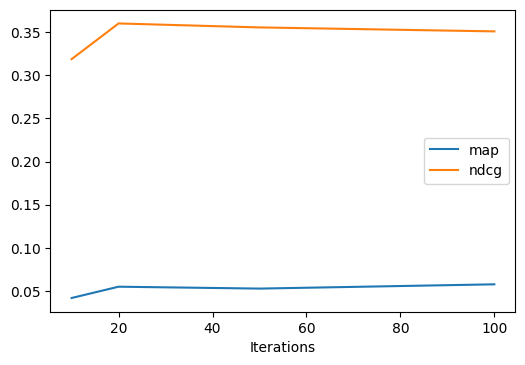

In [37]:
plt.figure(dpi=100)

plt.plot([10, 20, 50, 100], iterations_map, label="map")
plt.plot([10, 20, 50, 100], iterations_ndcg, label="ndcg")
plt.xlabel("Iterations")
plt.legend()

plt.show()